In [2]:
import tensorflow_datasets as tfds

In [3]:
ds=tfds.load("fashion_mnist",split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\dellb\tensorflow_datasets\fashion_mnist\3.0.1.incompleteJ1YT7R\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\dellb\tensorflow_datasets\fashion_mnist\3.0.1.incompleteJ1YT7R\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\dellb\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [7]:
import matplotlib.pyplot as plt

In [9]:
import numpy as np

In [8]:
dataiterator=ds.as_numpy_iterator()

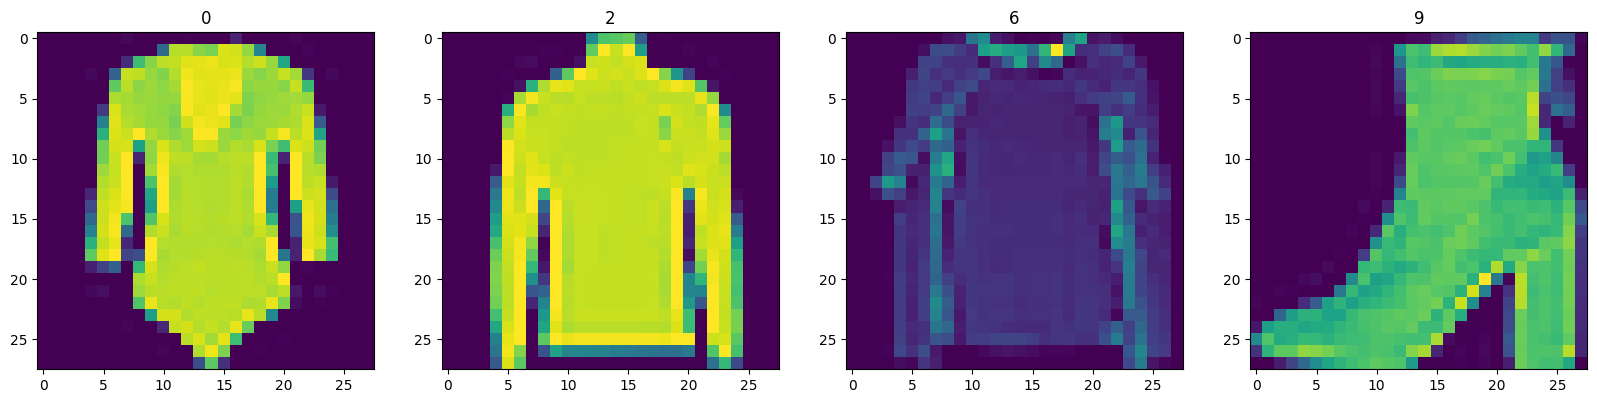

In [12]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    batch=dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [18]:
### scaling image
def scale_img(data):
    img=data['image']
    return img/255

### data pipeline

In [15]:
import tensorflow as tf

In [19]:
ds=ds.map(scale_img)
ds=ds.cache()
ds=ds.shuffle(60000)
ds=ds.batch(128)
ds=ds.prefetch(64)

In [20]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

### build generator

In [41]:
def build_generator():
    model=Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding="same"))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding="same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1,4,padding="same",activation="sigmoid"))
    
    return model

In [42]:
generator=build_generator()

In [43]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

### Dicriminator

In [57]:
def build_discriminator():
    model=Sequential()
    
    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [58]:
discriminator=build_discriminator()

In [59]:
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)     

## construct training loop

In [60]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [61]:
g_opt=Adam(learning_rate=0.0001)
d_opt=Adam(learning_rate=0.00001)
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [62]:
from tensorflow.keras.models import Model

In [89]:
class GAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator=generator
        self.discriminator=discriminator
    
    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        
        self.g_opt=g_opt
        self.d_opt=d_opt
        self.g_loss=g_loss
        self.d_loss=d_loss
        
    def train_step(self,batch):
        real_images=batch
        fake_images=self.generator(tf.random.normal((128,128,1)),training=False)
        
        with tf.GradientTape() as d_tape:
            yhat_real=self.discriminator(real_images,training=True)
            yhat_fake=self.discriminator(fake_images,training=True)
            yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)
            
            y_realfake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
            
            noise_real=0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake=-0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake+=tf.concat([noise_real,noise_fake],axis=0)
            
            total_d_loss=self.d_loss(y_realfake,yhat_realfake)
            
        d_grad=d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grad,self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape:
            gen_images=self.generator(tf.random.normal((128,128,1)),training=True)
            
            predicted_labels=self.discriminator(gen_images,training=False)
            
            total_g_loss=self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)
            
        g_grad=g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grad,self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss,"g_loss":total_g_loss}

In [90]:
fashgan=GAN(generator,discriminator)

In [91]:
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

### build callbacks

In [92]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [93]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## train

In [88]:
hist=fashgan.fit(ds,epochs=20,callbacks=[ModelMonitor()])

Epoch 1/20
 18/469 [>.............................] - ETA: 1:09:00 - d_loss: 0.6956 - g_loss: 0.6956

KeyboardInterrupt: 

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

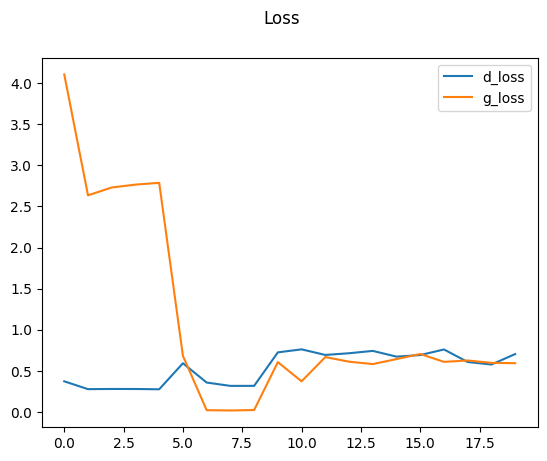

In [95]:
generator.load_weights('generator.h5')

In [98]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 102ms/step


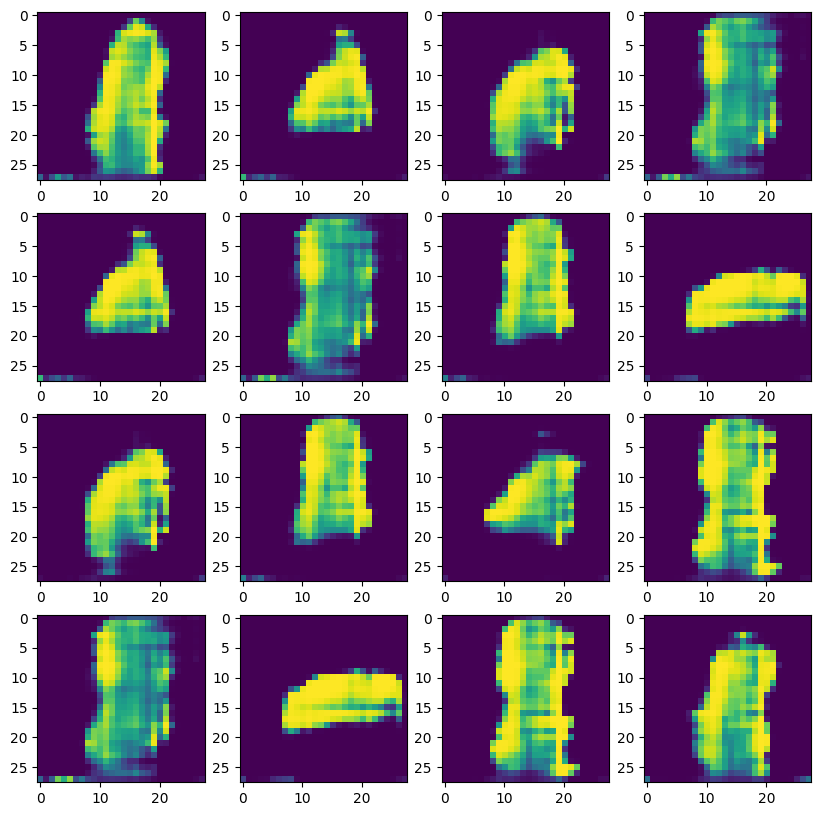

In [99]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

#### needs more epochs to perform better (more than 2000 epochs)